## Portfolio Optimization Tool
- A tool that decides how much money to put in each stock so that the portfolio gives the best risk-adjusted return (maximum Sharpe ratio).
- The Modern Portfolio Theory (MPT) refers to an investment theory that allows investors to assemble an asset portfolio that maximizes expected return for a given level of risk (A Random Walk Down Wallstreet, look at ETFs graph).
- Diversification does NOT come from holding many stocks, it comes from holding stocks that don’t move together perfectly.

### STEP 1: Download historical prices

In [4]:
import yfinance as yf
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models, expected_returns

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]

prices = yf.download(tickers, start="2019-01-01", end="2024-01-01")["Close"]
prices.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2019-01-02,37.538815,76.956497,52.338547,134.738815,94.612602
2019-01-03,33.799679,75.014000,50.888992,130.826157,91.131989
2019-01-04,35.242565,78.769501,53.499271,136.993042,95.370476
2019-01-07,35.164112,81.475502,53.392582,137.092377,95.492111
2019-01-08,35.834450,82.829002,53.861538,141.541306,96.184509


### STEP 2: Convert closing prices into returns

In [6]:
returns = prices.pct_change().dropna() # (Current value - Previous value)/ Previous value
returns.head()

# We use returns instead of prices because prices are non-stationary, and are highy autocorrelated with each other (dependent)

Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2019-01-03,-0.099607,-0.025241,-0.027696,-0.029039,-0.036788
2019-01-04,0.042689,0.050064,0.051294,0.047138,0.046509
2019-01-07,-0.002226,0.034353,-0.001994,0.000725,0.001275
2019-01-08,0.019063,0.016612,0.008783,0.032452,0.007251
2019-01-09,0.016982,0.001714,-0.003427,0.011927,0.014299


### STEP 3: Average Annual Returns (mean)
- Average Annual return = (sum of daily returns / number of days) × 252 

In [8]:
mean_returns = returns.mean() * 252 #252 trading days per year
mean_returns

Ticker
AAPL     0.378031
AMZN     0.198360
GOOGL    0.245988
META     0.289079
MSFT     0.320295
dtype: float64

### STEP 4: Covariance Matrix
- measure how stocks move together, because portfolio risk depends on relationships between stocks, not just how risky each one is alone.
- variace = How much does this one stock move up and down by itself.

In [10]:
cov_matrix = returns.cov() * 252
cov_matrix

# META → 0.190, AMZN → 0.124, AAPL → 0.104 (high variace / volatile)
# Cov(AAPL, MSFT) = 0.0746 → When AAPL goes up, MSFT tends to go up too, but not perfectly.

# covariance tells you: Do these two stocks tend to move in the same direction, and how strongly (in risk terms).
# Positive covariance = same direction
# Negative covariance = opposite direction
# 

Ticker,AAPL,AMZN,GOOGL,META,MSFT
Ticker,,,,,
AAPL,0.103907,0.070302,0.069207,0.083255,0.074562
AMZN,0.070302,0.124055,0.073902,0.094286,0.073346
GOOGL,0.069207,0.073902,0.101188,0.093134,0.073616
META,0.083255,0.094286,0.093134,0.190358,0.082489
MSFT,0.074562,0.073346,0.073616,0.082489,0.092969


### STEP 5: Portfolio risk & return (conceptual pause)
- Once you know returns and covariances, a portfolio is just weights
- Portfolio return = weighted average of individual returns
- Example: AAPL return = 10% and MSFT return = 6% then → Rp = (0.6×10%)+(0.4×6%)=8.4%
- Porfolio Risk = How risky each stock is (variance), How stocks move together (covariance), How much you invest in each (weights)
- Example: Two volatile stocks, If they move together → risk stays high but if they move differently → risk drops

### STEP 6: Best Practice
- We are letting pyportfolioopt do the Average annual returns and the covariance matrix (as computed above manually)
- It is about Best Practice

In [13]:
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# mu = expected annual returns
# S = annualized covariance matrix
# It’s about best practice.

### STEP 8: Maximize Sharpe Ratio
- Sharpe ratio = how much return you get for each unit of risk you take (risk adjusted return)
- High Sharpe = efficient use of risk. Low Sharpe = taking a lot of risk for little reward
- Formula = (Portfolio Return - Risk-free Rate) / Standard deviation(volatitily) → taken from the covariance matrix and weights
- What optimization is really searching for: Given all possible portfolios, which one gives me the most return per unit of risk (maximize sharpe ratio).

In [15]:
ef = EfficientFrontier(mu, S) #this is our porfolio

ef.max_sharpe() #Computes return and risk for each, Picks the weights with highest Sharpe (Rf close to 0)
clean_weights = ef.clean_weights() #Rounds tiny numbers to 0
clean_weights

# Adding AMZN / GOOGL / META: Adds more of the same movement. Adds volatility. Adds little diversification benefit

# To maximize the Sharpe ratio, the optimal portfolio is:

OrderedDict([('AAPL', 0.756),
             ('AMZN', 0.0),
             ('GOOGL', 0.0),
             ('META', 0.0),
             ('MSFT', 0.244)])

### STEP 9: Interpret the portfolio performance

In [17]:
performance = ef.portfolio_performance(verbose=True)

# 36.8% expected return, based on historical average returns
# 30.4% volatility. Pretty risky
# Sharpe = 1.21. Very strong risk adjusted return. 

Expected annual return: 36.8%
Annual volatility: 30.4%
Sharpe Ratio: 1.21


### STEP 10: Plot the Efficient Frontier

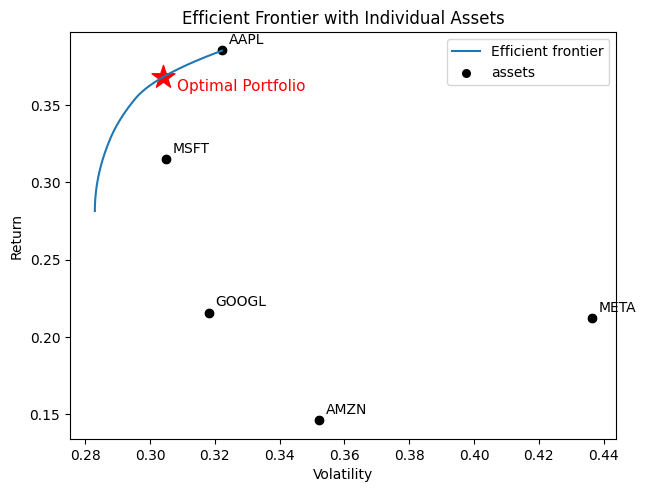

InstantiationError: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.

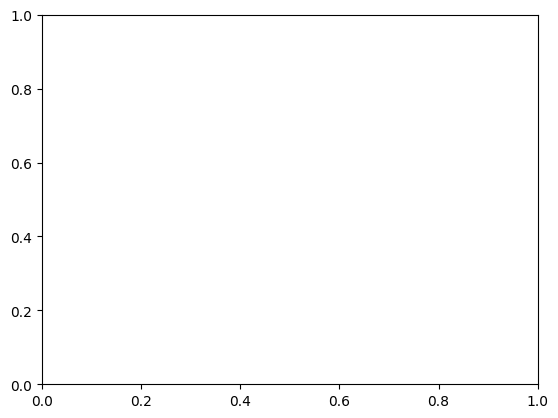

In [21]:
import matplotlib.pyplot as plt
from pypfopt import plotting

ef_p = EfficientFrontier(mu, S) #Create a NEW EfficientFrontier object just for plotting

# Plot efficient frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_p, ax=ax, show_assets=True)

# add labels to each asset
for ticker in mu.index:
    x = S.loc[ticker, ticker] ** 0.5   # volatility = sqrt(variance)
    y = mu[ticker]                     # expected return
    
    ax.scatter(x, y, color="black")
    ax.annotate(
        ticker,
        (x, y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10)
    
# optimal portfolio
port_ret, port_vol, port_sharpe = ef.portfolio_performance()

ax.scatter(
    port_vol,
    port_ret,
    marker="*",
    s=300,
    color="red",
    label="Max Sharpe Portfolio")
ax.annotate(
    "Optimal Portfolio",
    (port_vol, port_ret),
    xytext=(10, -10),
    textcoords="offset points",
    fontsize=11,
    color="red")

ax.set_title("Efficient Frontier with Individual Assets")
plt.show()
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_p, ax=ax, show_assets=True)
plt.show()

# MSFT has slightly lower return than AAPL, but also slightly lower risk, a combination of assets can beat MSFT alone